<a href="https://colab.research.google.com/github/pipuf/ml_dev_cert/blob/main/15_1_1_THEORY_MLP_with_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP for Customer Churn prediction

Based upon data of clients of a bank we calculate whether a customer stands a chance to stay in the company or not.

We will use the [following dataset](https://www.kaggle.com/datasets/shubh0799/churn-modelling).

We may find the following features in the data:

- CustomerId: The unique customer id
- Surname: Customers' Surname
- CreditScore: Their credit score
- Geography: Which Country do they belong to
- Gender: Their Gender
- Age: Age
- Tenure The time of bond with the company
- Balance: The amount left with them
- NumOfProducts: The products they own
- HasCrCard: Do they have a credit card or not
- IsActiveMember: How active members they are
- EstimatedSalary: Their estimated salary
- Exited: Whether they stay in the company or leave


In [ ]:
!nvidia-smi

Thu Feb 13 23:10:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 46.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tensorflow import keras
from tensorflow.keras import layers
import visualkeras


In [ ]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

## Load dataset

In [ ]:
!gdown "1Tv_kSKRkyLhcRZgzvYZzeWBm3Qv9XxRy"

data = pd.read_csv("Churn_Modelling.csv")
data

Downloading...
From: https://drive.google.com/uc?id=1Tv_kSKRkyLhcRZgzvYZzeWBm3Qv9XxRy
To: /content/Churn_Modelling.csv
100% 685k/685k [00:00<00:00, 138MB/s]


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Feature engineering

In [ ]:
# Let's check if we have NaNs
data.isna().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [ ]:
# Let's drop some columns we shouldn't use
data = data.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [ ]:
# Separate features and target (Exited will be our target)
X = data[data.columns.drop("Exited")]
y = data["Exited"]

print(X.shape, y.shape)

(10000, 10) (10000,)


In [ ]:
# Do train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 10) (2000, 10) (8000,) (2000,)


### Prepare Numeric and Non-numeric features

In [ ]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
print(f"There are {len(numerical_features)} numerical features: {numerical_features}\n")

string_features = X_train.select_dtypes(exclude='number').columns.tolist()
print(f"There are {len(string_features)} string features: {string_features}\n")


There are 8 numerical features: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

There are 2 string features: ['Geography', 'Gender']



In [ ]:
# Pipeline for numeric features
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
  ]
)

# Pipeline for string features
string_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
  ]
)

# Now let's merge both pipeline into one single pre-processing object
# We can use ColumnTransformer for this
full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('string', string_pipeline, string_features)
  ]
)


In [ ]:
X_train_p = full_processor.fit_transform(X_train)
X_test_p = full_processor.transform(X_test)

print(X_train_p.shape, X_test_p.shape)

(8000, 13) (2000, 13)


In [ ]:
X_train_p[0]

array([-1.22610329, -0.74986619, -0.69271963, -1.21691622, -0.91838017,
        0.64337173,  0.98093177, -0.99426055,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ])

## Define the model

In [ ]:
X_train_p[0].shape

(13,)

In [ ]:
# Let's create a simple MLP with Keras
model = keras.Sequential()
model.add(layers.Dense(60, input_dim=13, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(3, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 60)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           1,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │             620 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             105 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │               4 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,347 (16.98 KB)

 Trainable params: 4,347 (16.98 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
visualkeras.layered_view(model, legend=False)

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [ ]:
# We must compile the keras model before training
# During compile we must define:
#  - Loss functions to be used
#  - Optimizer, we will see more about this in "Training tips and tricks"
#  - Metrics, for this particular case we have a classification problem so we
#    can use accuracy
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy'],
)


In [ ]:
# Now we can start training
history = model.fit(
  X_train_p,
  y_train,
  epochs=50,
  batch_size=16,
  validation_split=0.2
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7814 - loss: 0.5290 - val_accuracy: 0.8238 - val_loss: 0.3957
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8358 - loss: 0.3855 - val_accuracy: 0.8606 - val_loss: 0.3435
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8579 - loss: 0.3519 - val_accuracy: 0.8662 - val_loss: 0.3423
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8662 - loss: 0.3217 - val_accuracy: 0.8669 - val_loss: 0.3360
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8755 - loss: 0.3122 - val_accuracy: 0.8619 - val_loss: 0.3364
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8701 - loss: 0.3200 - val_accuracy: 0.8681 - val_loss: 0.3334
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8741 - loss: 0.3083 - val_accuracy: 0.8675 - val_loss: 0.3338
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8709 - loss: 0.3158 - val_accuracy: 0.

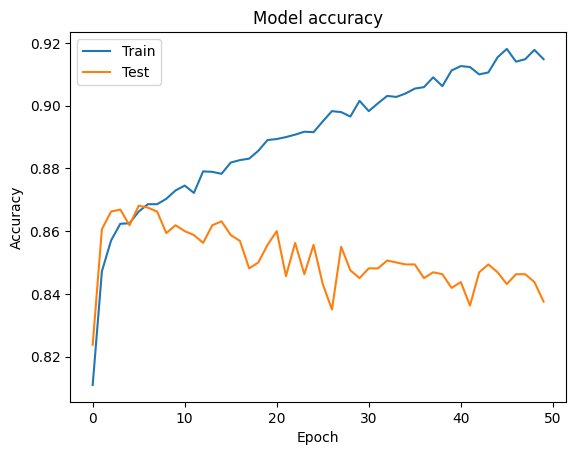

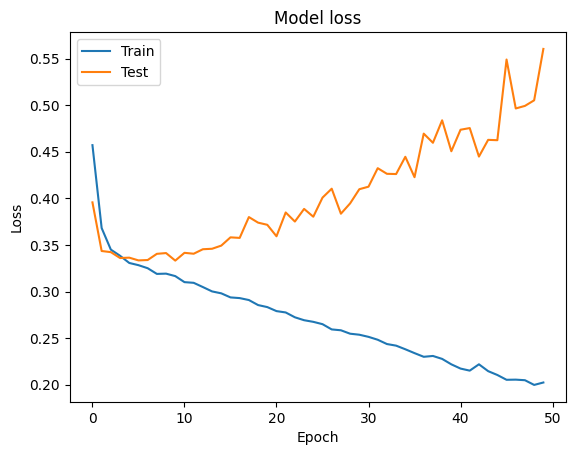

In [ ]:
plot_history(history)

## Let's compare with other types of models


In [ ]:
%%time

# Let's create a pipeline re-using the preprocessing
# but adding a DecisionTreeClassifier
tree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', DecisionTreeClassifier())
  ]
)

param_dist = {
  "model__max_depth": [2, 3, 5, 10, None],
  "model__splitter": ["best", "random"],
  "model__max_features": scipy.stats.randint(1, 13),
  "model__min_samples_leaf": scipy.stats.randint(1, 25),
  "model__criterion": ["gini", "entropy"]
}

rsearch = RandomizedSearchCV(
  tree_pipeline,
  param_dist,
  n_iter=150,
  scoring="accuracy",
  cv=5,
  n_jobs=-1,
  random_state=2023,
)

rsearch.fit(X_train, y_train)


CPU times: user 1.73 s, sys: 190 ms, total: 1.92 s
Wall time: 22.8 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('number',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                StandardScaler())]),
                                                                               ['CreditScore',
                                                                                'Age',
                                                                                'Tenure',
                                                                                'Balance',
                                                                                'NumOfProducts',
                                                                                'HasCrCard',
                                                                                'IsActiveMember',
                                                                                'EstimatedSalary']),
                                                                              ('string',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer(strategy='most_fr...
                   param_distributions={'model__criterion': ['gini', 'entropy'],
                                        'model__max_depth': [2, 3, 5, 10, None],
                                        'model__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eb2639ed350>,
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eb2639ed410>,
                                        'model__splitter': ['best', 'random']},
                   random_state=2023, scoring='accuracy')

In [ ]:
rsearch.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 5,
 'model__max_features': 11,
 'model__min_samples_leaf': 12,
 'model__splitter': 'best'}

In [ ]:
 rsearch.best_score_

0.85625

## But you told me Neural Networks were the best!!! ヽ(ಠ_ಠ)ノ

Yes! But we may have to carefully tune our neural network architecture and hyperparameters in order to make it work properly.

One easy way is to use [Keras Tuner](https://keras.io/keras_tuner/). We will see more about this in the next few days.
